In [ ]:
# Cell 1: Общее конфигурирование

from agentslab.utils.device import resolve_device
from agentslab.utils.seeding import set_global_seed
from pathlib import Path

device = resolve_device()
 
seed = 42
set_global_seed(seed, deterministic=True)

ROOT = Path('..').resolve()
ALGO_NAME, ENV_NAME = "ppo", "pendulum"
ENV_ID = "InvertedDoublePendulum-v4"

In [20]:
# DRAFT

from datetime import datetime
from agentslab.utils.checkpointers import CheckpointInfo, save_checkpoint, load_checkpoint

run_name = f"ppo_gym_demo_{datetime.now().strftime('%Y%m%d-%H%M%S')}"


LOGS_ROOT = (ROOT / 'logs').resolve()
CKPT_ROOT = (ROOT / 'checkpoints').resolve()
LOGS_ROOT.mkdir(exist_ok=True)
CKPT_ROOT.mkdir(exist_ok=True)

log_dir = LOGS_ROOT / run_name
ckpt_info = CheckpointInfo(algo='ppo', env_id='InvertedDoublePendulum-v4', run_name='demo', dir_root=str(CKPT_ROOT))
run_ckpt_dir = ckpt_info.make_run_dir()

from agentslab.utils.logger import CSVLogger
from agentslab.utils.curves import plot_training_curves


logger = CSVLogger(str(log_dir))
print('Device:', device)
print('Log dir:', log_dir)
print('Checkpoint dir:', run_ckpt_dir)

Device: cpu
Log dir: C:\Users\ordevoir\Documents\GitHub\AgentsLab\logs\ppo_gym_demo_20250820-131235
Checkpoint dir: C:\Users\ordevoir\Documents\GitHub\AgentsLab\checkpoints\ppo_InvertedDoublePendulum-v4_demo_20250820-131235


In [21]:
# Создание среды
from agentslab.envs.gym_factory import GymEnvConfig, make_gym_env
from agentslab.utils.specs import print_specs

env_cfg = GymEnvConfig(env_id=ENV_ID, render_mode=None, device=device, seed=seed)
env = make_gym_env(env_cfg)

# print_specs(env)

In [ ]:
# Создание актора и критика
from agentslab.modules.networks import MLPConfig, build_mlp
from agentslab.modules.policy import build_stochastic_actor
from torchrl.modules import ValueOperator

# Достаём размерности
obs_dim = env.observation_spec["observation"].shape[-1]
act_dim = env.action_spec.shape[-1]

mlp_cfg = MLPConfig(
        in_dim = obs_dim, 
        out_dim = 2*act_dim,
        hidden_sizes = (256, 256),
        activation = "tanh",
        layer_norm = False
)

actor_network = build_mlp(mlp_cfg)
actor = build_stochastic_actor(actor_network, env.action_spec)

mlp_cfg.out_dim = act_dim
critic_network = build_mlp(mlp_cfg)
critic = ValueOperator(module=critic_network, in_keys=["observation"])

# Collector

In [ ]:
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

frames_per_batch = 1000
# For a complete training, bring the number of frames up to 1M
total_frames = 10_000

collector = SyncDataCollector(
    env,
    actor,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

# Loss Function

In [37]:
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
import torch

gamma = 0.99
lmbda = 0.95

advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=critic, average_gae=True
)

clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
entropy_eps = 1e-4

loss_module = ClipPPOLoss(
    actor_network=actor,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coeff=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coeff=1.0,
    loss_critic_type="smooth_l1",
)

lr = 3e-4

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optim, 
    T_max=total_frames // frames_per_batch, 
    eta_min=0.0
)

In [ ]:
from collections import defaultdict
from tqdm import tqdm

logs = defaultdict(list)
pbar = tqdm(total=total_frames)
max_grad_norm = 1.0
eval_str = ""

  0%|          | 0/10000 [00:00<?, ?it/s]

Мы перебираем `collector`, пока он не достигнет общего количества кадров, на сбор которых он был рассчитан (`total_frames`). На каждой итерации `tensordict_data`

In [ ]:
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type

num_epochs = 10
sub_batch_size = 64


# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.DETERMINISTIC), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, actor)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

eval cumulative reward:  129.3660 (init:  92.3381), eval step-count: 13, average reward= 9.1101 (init= 9.0960), step count (max): 14, lr policy:  0.0000:  90%|█████████ | 9000/10000 [24:26<00:35, 28.47it/s]

eval cumulative reward:  129.3660 (init:  92.3381), eval step-count: 13, average reward= 9.1101 (init= 9.0960), step count (max): 14, lr policy:  0.0000:  90%|█████████ | 9000/10000 [24:36<00:35, 28.47it/s]

In [ ]:
from collections import defaultdict

d = defaultdict(int)   # int() -> 0
d['a'] += 1            # ключа 'a' не было → создаётся 0, затем становится 1
print(d)

defaultdict(<class 'int'>, {'a': 1})


In [43]:
d = defaultdict(list)
d["b"]

[]

In [26]:
# Cell 3: Конфигурирование trainer и запуск обучения
from agentslab.runners.trainers import PPOTrainer, PPOTrainerConfig
from agentslab.runners.evals import EvalConfig, evaluate_policy

trainer_cfg = PPOTrainerConfig(
    frames_per_batch=1024,
    total_frames=20_480,  # демо; поднимайте до 1e6 для реальных результатов
    sub_batch_size=64,
    num_epochs=10,
    lr=3e-4,
    max_grad_norm=1.0,
    gamma=0.99,
    lam=0.95,
    clip_epsilon=0.2,
    entropy_coef=1e-4,
    seed=seed,
    device=device,
    eval_every=5,
)

def evaluator():
    return evaluate_policy(env, actor, EvalConfig(steps=1000, device=device))

trainer = PPOTrainer(trainer_cfg, env, actor, critic, run_dirs={'ckpt': run_ckpt_dir, 'logs': str(log_dir)}, logger=logger)
trainer.train(evaluator=evaluator)

# Сохранение чекпоинта
ckpt_path = save_checkpoint(run_ckpt_dir, actor, critic, None, None, extra={'iter_done': trainer_cfg.total_frames // trainer_cfg.frames_per_batch})
print('Saved to:', ckpt_path)


c:\Users\ordevoir\miniconda3\envs\marl\Lib\site-packages\torchrl\objectives\ppo.py:384: DeprecationWarning: 'critic_coef' is deprecated and will be removed in torchrl v0.11. Please use 'critic_coeff' instead.
  warnings.warn(
c:\Users\ordevoir\miniconda3\envs\marl\Lib\site-packages\torchrl\objectives\ppo.py:450: DeprecationWarning: 'entropy_coef' is deprecated and will be removed in torchrl v0.11. Please use 'entropy_coeff' instead.
  warnings.warn(
Collect/Train:   0%|          | 0/20 [00:00<?, ?it/s]

Collect/Train: 100%|██████████| 20/20 [01:33<00:00,  4.68s/it]

Saved to: C:\Users\ordevoir\Documents\GitHub\AgentsLab\checkpoints\ppo_InvertedDoublePendulum-v4_demo_20250820-131235\checkpoint.pt


In [ ]:
# Cell 4: Конфигурирование и оценка модели
from agentslab.runners.evals import EvalConfig, evaluate_policy
eval_res = evaluate_policy(env, actor, EvalConfig(steps=1000, device=device))
eval_res


{'eval_return': 2222.6134170452133, 'eval_steps': 1000}

CSV: C:\Users\ordevoir\Documents\GitHub\AgentsLab\logs\ppo_gym_demo_20250819-022636\train_log.csv


<Figure size 640x480 with 0 Axes>

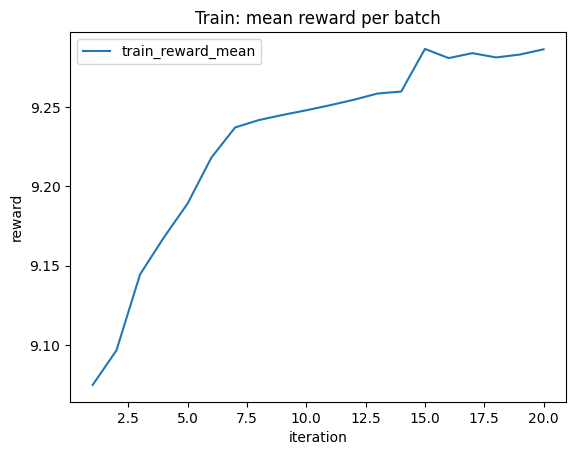

<Figure size 640x480 with 0 Axes>

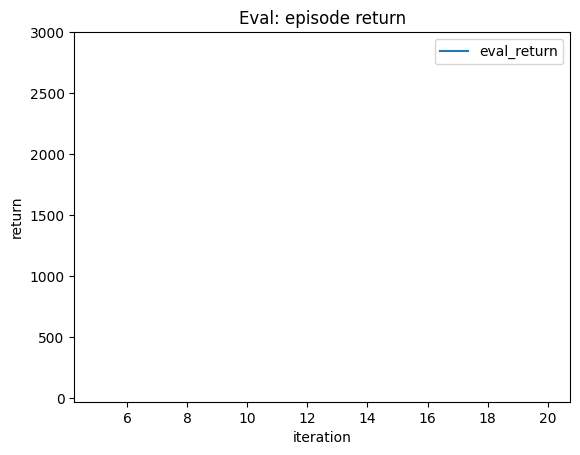

<Figure size 640x480 with 0 Axes>

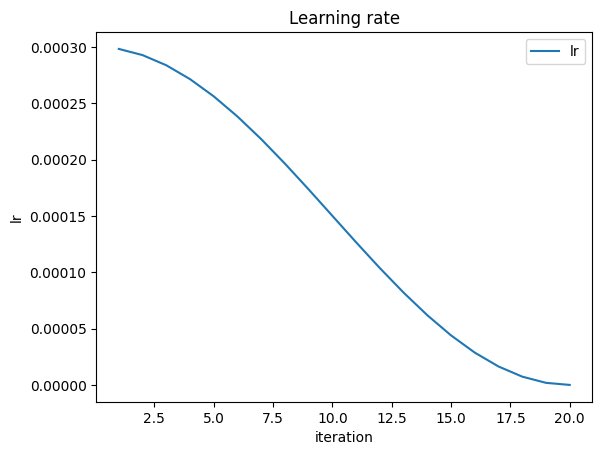

In [ ]:
# Cell 5: Построение графиков по логам (matplotlib)
import matplotlib.pyplot as plt
csv_path = (log_dir / 'train_log.csv')
print('CSV:', csv_path)
from agentslab.utils.curves import plot_training_curves
plot_training_curves(str(csv_path))
plt.show()


In [ ]:
# Cell 6: Запуск среды с выбранным render_mode
from torchrl.envs.utils import ExplorationType, set_exploration_type
from tqdm import tqdm

if env_cfg.render_mode is None:
    print('Пересоздаём env с render_mode="human" для визуализации...')
    env_cfg_vis = GymEnvConfig(env_id=env_cfg.env_id, render_mode='human', device=device, seed=seed)
    env_vis = make_gym_env(env_cfg_vis)
else:
    env_vis = env

with torch.no_grad():
    with set_exploration_type(ExplorationType.DETERMINISTIC):
        td = env_vis.reset()
        for _ in tqdm(range(500)):
            td = actor(td)
            td = env_vis.step(td)
            td = td.get('next')

env_vis.close()


Пересоздаём env с render_mode="human" для визуализации...


100%|██████████| 500/500 [00:08<00:00, 60.06it/s]


In [ ]:
# Cell 7: Восстановление модели из чекпоинта
from agentslab.utils.checkpointers import load_checkpoint
loaded = load_checkpoint(str(Path(run_ckpt_dir) / 'checkpoint.pt'), actor, critic)
print('Loaded extra:', loaded)


Loaded extra: {'iter_done': 20}
